In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time, sleep
import threading
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo
import time

%matplotlib inline

In [2]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Function to track GPU memory usage
def track_gpu_utilization(interval=1):
    memory_usage = []
    timestamps = []
    
    # Define a helper function to gather GPU memory usage
    def record_utilization():
        while tracking:
            mem = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert to GB
            memory_usage.append(mem)
            timestamps.append(time() - start_time)
            sleep(interval)  # Wait before recording again

    # Start tracking in a separate thread
    tracking = True
    start_time = time()
    tracking_thread = threading.Thread(target=record_utilization)
    tracking_thread.start()
    
    return memory_usage, timestamps, lambda: tracking_thread.join()
# Visualization function
def plot_gpu_utilization(memory_usage, timestamps):
    clear_output(wait=True)
    plt.plot(timestamps, memory_usage, label='GPU Memory Usage (GB)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Memory Usage (GB)')
    plt.title('GPU Memory Utilization Over Time')
    plt.legend()
    plt.show()

def print_peak_gpu_memory():
    peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # in MB
    print(f"Peak GPU memory used: {peak_memory:.2f} MB.")
    torch.cuda.reset_peak_memory_stats()  # Reset after printing


def print_gpu_utilization():
    nvmlInit()  # Initialize NVML
    handle = nvmlDeviceGetHandleByIndex(0)  # Assuming we're using GPU 0
    info = nvmlDeviceGetMemoryInfo(handle)  # Get memory info
    print(f"GPU memory occupied: {info.used // 1024**2} MB.")
print_gpu_utilization()  # Print memory before starting the optimization loop


GPU memory occupied: 254 MB.


In [4]:
# Visualization function using tolist()
def visualize_glacier(x, Z, Z_bed, z_ELA, b, Time):
    Z_list = Z.cpu().tolist()  # Convert to list
    Z_bed_list = Z_bed.cpu().tolist()  # Convert to list
    x_list = x.cpu().tolist()  # Convert to list
    b_list = b.cpu().tolist()  # Convert to list
    clear_output(wait=True)  # Clear the previous output in the notebook
    
    plt.figure(2, figsize=(7, 5), dpi=200)
    plt.subplot(2, 2, 1)
    plt.plot([xi / 1000 for xi in x_list], Z_list, 'b', linewidth=2) 
    plt.plot([xi / 1000 for xi in x_list], Z_bed_list, 'k', linewidth=1)
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [z_ELA, z_ELA], 'g')
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.ylabel('Elevation, m')
    plt.title('Glacier après ' + str(int(Time)) + ' années')

    plt.subplot(2, 2, 2)
    plt.plot([min(grad_b * (zi - z_ELA), b_max) for zi in Z_list], Z_list, '--k', linewidth=2)
    plt.plot([min(b_list), b_max + 0.3], [z_ELA, z_ELA], 'g')
    plt.plot([0, 0], [min(Z_bed_list), max(Z_bed_list)], 'k', linewidth=1)
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.title('Fonction bilan de masse') 
    plt.xlabel('Bilan de masse, m/a')  

    plt.subplot(2, 2, 3, aspect=20.0)
    plt.plot([xi / 1000 for xi in x_list], b_list, 'b', linewidth=2)
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [0, 0], 'k', linewidth=1)
    plt.title('Bilan de masse effectif')
    plt.xlabel('Distance, km') 
    plt.ylabel('Bilan de masse, m/a') 

    plt.show()
    
def compute_slope(Z, dx):
    # Compute the slope (gradient of surface) using finite difference
    slope = torch.diff(Z) / dx
    return slope


In [5]:
# Physics
b_max = 0.3  # maximum ice balance m/yr
grad_b = 0.001  # gradient of ice balance as a function of elevation. yr^-1

z_ELA = 1200  # equilibrium line altitude
Lx = 3e5  # model length, m
ttot = 700  # total time
rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
fd = 1e-15  # physical constant for ice diffusivity, Pa^3/y
kD = fd * rhog**3  # lump all constants for diffusivity together
epsilon = 1e-12 # Epsilon to avoid division by zero



# Numerics
nx = 201  # number of cells
dx = Lx / (nx - 1)  # number of cells 
dtmax = 1      # initial dt, will be changed within loop, yr
dt    = dtmax  # initial dt, will be changed within loop, yr
x = torch.linspace(0, Lx, nx, device=device)  # x-coordinates
nout = 100  # frequency of plotting

# Initialization
Z_bed = -1000 * torch.log(x + 1000) + 11522.8  # topography
H_initial= torch.zeros(nx, device=device) #torch.load('initial_thickness.pt', weights_only=True).to(device)
H = H_initial.clone()
Time = 0.0  # initialize time
nplot = 0  # counter for plotting

Z = Z_bed + H  # ice surface

it = 0


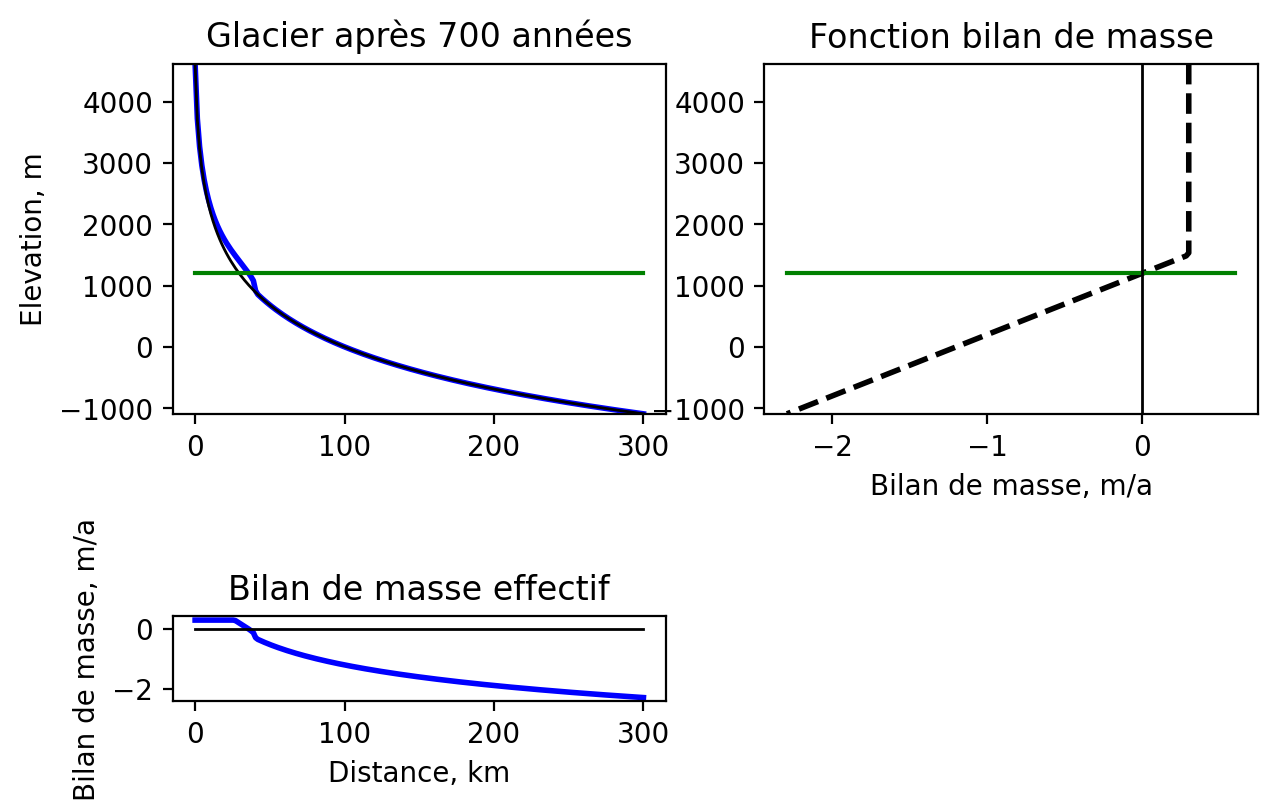

Elapsed time is : 1.5607357025146484 s


In [6]:
# Initialize lists to store data for training
data = []

# Time loop
start = time.time()

while Time < ttot:

    # compute dHdt due to diffusion
    H_av = 0.5 * (H[:-1] + H[1:])  # average height between cells (nx-1)
    D = kD * H_av**5 * (torch.diff(Z) / dx)**2  # diffusivity (nx-1)
    qx = -D * torch.diff(Z) / dx  # ice flux

    dHdt = -torch.diff(qx) / dx  # change in ice thickness from flow

    # update time step as function of D
    max_D = torch.max(D).item()
    dt = min(dtmax, dx**2 / (2.1 * (max_D + epsilon)))  # update time step

    # update thickness of ice (iceflow)
    H[1:-1] += dt * dHdt  # update ice thickness from flow

    # update ice thickness (mass balance)
    b = torch.minimum(grad_b * (Z - z_ELA), torch.tensor(b_max, device=device)) 
    H[1:-1] += dt * b[1:-1]

    H[H < 0] = 0  # set any negative thickness to 0

    # Boundary conditions
    H[0] = 0
    H[-1] = 0

    Z = Z_bed + H  # update ice surface
    Time += dt  # update time

    it += 1


    # Call visualization function
    if it % nout == 0:
 
        visualize_glacier(x, Z, Z_bed, z_ELA, b, Time)
end = time.time()
print(f"Elapsed time is : {end - start} s")

In [7]:
# Sav e the observations.
torch.save(H,'observed_thk.pt')


In [8]:
H_initial

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [20]:
# Function to perform forward simulation of glacier thickness with differentiable operations
def forward_simulation(H_initial,b_max, grad_b,z_ELA, nx=201, Lx=1e5, ttot=3e3, dtmax=1, device=device,display_time=False):
    start= time.time()
    # Physics constants
    n=3
    rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
    fd = 1e-15  # physical constant for ice diffusivity, Pa^3/y
    kD = fd * rhog**n  # lump all constants for diffusivity together
    Lx = 3e5  # model length, m
    dx = Lx / (nx - 1)  # cell size
    epsilon = 1e-12

    # Numerics
    nx = 201  # number of cells
    dx = Lx / (nx - 1)  # number of cells 
    dtmax = 1      # initial dt, will be changed within loop, yr
    dt    = dtmax  # initial dt, will be changed within loop, yr
    Time = 0

    # Initialization
    x = torch.linspace(0, Lx, nx, device=device)  # x-coordinates
    Z_bed = -1000 * torch.log(x + 1000) + 11522.8  # topography (avoid log(0))
    H = H_initial.clone()  # initial ice thickness
    Z = Z_bed + H  # ice surface
    print(f"H_initial type: {type(H_initial.clone())}, shape: {H_initial.shape}")

    while Time < ttot:
        # compute dHdt due to diffusion
        H_av = 0.5 * (H[:-1] + H[1:])  # average height between cells (nx-1)
        D = kD * H_av**5 * (torch.diff(Z) / dx)**(n-1)  # diffusivity (nx-1)
        qx = -D * torch.diff(Z) / dx  # ice flux
        # Compute velocity safely
        dHdt = -torch.diff(qx) / dx  # change in ice thickness from flow
        
        # update time step as function of D
        max_D = torch.max(D).item()
        dt = min(dtmax, dx**2 / (2.1 * (max_D + epsilon)))  # update time step

        # update thickness of ice (iceflow)
        H[1:-1] += dt * dHdt  # update ice thickness from flow
    
        # update ice thickness (mass balance)
        b = torch.minimum(grad_b * (Z - z_ELA), torch.tensor(b_max, device=device)) 
        H[1:-1] += dt * b[1:-1]
    
        H[H < 0] = 0  # set any negative thickness to 0
    
        # Boundary conditions
        H[0] = 0
        H[-1] = 0
    
        Z = Z_bed + H  # update ice surface
        Time += dt  # update time
    if display_time:
        end = time.time()
        print(f"Elapsed time is : {end - start} s")    
    return H

In [21]:
H_cal=forward_simulation(H_initial,b_max, grad_b, z_ELA,ttot=ttot)
observed_thk = torch.load('observed_thk.pt', weights_only=True).to(device)

H_initial type: <class 'torch.Tensor'>, shape: torch.Size([201])


In [13]:
H_initial.clone()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:
diff = H_cal - observed_thk
rmse = torch.sqrt(torch.mean(diff**2))
print(f"RMSE: {rmse.item()}")


In [ ]:
diff

In [ ]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()
# Initial guesses for inversion problem
b_max = 0.3
grad_b = 0.001
z_ELA = torch.tensor(1000.0, requires_grad=True, device=device)

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('observed_thk.pt', weights_only=True).to(device) # Ensure it's on the right device

# Optimizer setup
optimizer = torch.optim.Adam([z_ELA], lr=1)

# Regularization weight (tune this value)
reg_lambda = 0.0001

# Optimization loop
n_iterations = 10



# Initialize lists to track loss components
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history=[]
ELA_evolution=[]

for i in range(n_iterations):
    optimizer.zero_grad()  # Zero gradients
    
    # Perform forward simulation
    H_simulated = forward_simulation(b_max, grad_b, z_ELA,ttot=ttot)

    # Compute data fidelity and regularization
    data_fidelity = torch.mean((H_simulated - observed_thk))
    smoothness_reg = torch.sum((H_simulated[1:] - H_simulated[:-1]) ** 2)
    
    # Compute total loss
    loss = data_fidelity + reg_lambda * smoothness_reg
    
    # Backpropagate loss and update parameters
    loss.backward()

    # Store the gradients and ela 
    total_gradients_history.append(z_ELA.grad.item())
    # ELA_evolution.append(z_ELA.cpu().detach().numpy())

    optimizer.step()

    
    # Store loss components for plotting later
    total_loss_history.append(loss.item())
    data_fidelity_history.append(data_fidelity.item())
    regularization_history.append((reg_lambda * smoothness_reg).item())
        # Print loss, gradients and current parameters every 50 iterations 
    if (i + 1) % 1 == 0:
        print(f"\nIteration {i+1}/{n_iterations}, Loss: {data_fidelity:.3f} Reg: {reg_lambda*smoothness_reg:.3f}")
        print(f"ELA is {z_ELA} m")

print_gpu_utilization()  # Print memory after the loop
print_peak_gpu_memory()  # Print the peak memory 

Try to add the gradient*learning rate to the ELA

In [ ]:
z_ELA

In [ ]:
# Stop tracking and plot results when done
# stop_tracking()  # Wait for tracking thread to finish
# plot_gpu_utilization(memory_usage, timestamps)

In [ ]:
total_gradients_history

In [ ]:
plt.figure(figsize=(10,6))
# plt.plot(ELA_evolution,label="evolution of ELA",color='b')
plt.plot(total_gradients_history, label='Evolution of gradients')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
# Function to plot the loss function components
def plot_loss_components(total_loss_history, data_fidelity_history, regularization_history):
    plt.figure(figsize=(10, 6))

    # Plot the total loss, data fidelity, and regularization term
    plt.plot(total_loss_history, label='Total Loss', color='b', linewidth=2)
    plt.plot(data_fidelity_history, label='Data Fidelity', color='g', linestyle='--', linewidth=2)
    plt.plot(regularization_history, label='Regularization (Smoothness)', color='r', linestyle='-.', linewidth=2)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Components Over Iterations')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# After the optimization loop
plot_loss_components(total_loss_history, data_fidelity_history, regularization_history)


### Conceptual step

In [ ]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()
# Initial guesses for inversion problem
b_max = 0.3
grad_b = torch.tensor(0.001, requires_grad=True, device=device)
z_ELA = torch.tensor(1000.0, requires_grad=True, device=device)

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('observed_thk.pt', weights_only=True).to(device) # Ensure it's on the right device

# Optimizer setup
optimizer = torch.optim.Adam([z_ELA,grad_b], lr=1)

# Regularization weight (tune this value)
reg_lambda = 0.01

optimizer.zero_grad()  # Zero gradients

# Perform forward simulation
H_simulated = forward_simulation(b_max, grad_b, z_ELA)
# Compute data fidelity and regularization
data_fidelity = torch.mean((H_simulated - observed_thk) ** 2)
smoothness_reg = torch.sum((H_simulated[1:] - H_simulated[:-1]) ** 2)

# Compute total loss
loss = data_fidelity + reg_lambda * smoothness_reg

# Print the gradient of z_ELA before optimizer step


# # Backpropagate loss and update parameters
loss.backward()
print(f"Gradient of z_ELA: {z_ELA.grad.item()}")
print(f"Gradient of z_ELA: {grad_b.grad.item()}")
# optimizer.step()